# Project September — Quantum Kernel SVM (Starter Notebook)
**Generated:** 2025-09-03 17:02

This notebook is a scaffold for your assignment:
- Step 1: Train and evaluate a **classical SVM** with a kernel of your choice.
- Step 2: Build a **quantum feature map** (circuit), compute a **quantum kernel**, and use it with SVM.
- (Optional) Add **learnable parameters** to the quantum feature map and optimize them (learning kernels).


In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Install Qiskit if not already installed
%pip install --upgrade qiskit-machine-learning

%pip install qiskit-aer

import qiskit_machine_learning
print("version:", qiskit_machine_learning.__version__)

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.metrics import accuracy_score, classification_report


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
version: 0.8.4



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1) Load the provided train/test data

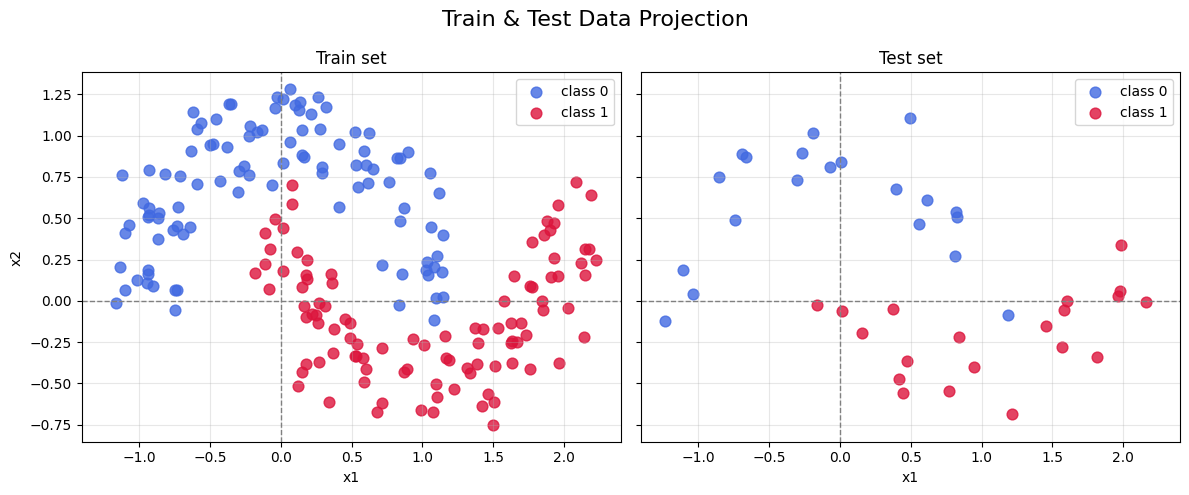

In [27]:
def subplot_train_test(X_train, y_train, X_test, y_test, title="Train & Test Data Projection"):
    # If more than 2 features → reduce with PCA
    if X_train.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_train_2d = pca.fit_transform(X_train)
        X_test_2d  = pca.transform(X_test)
        xlabel, ylabel = "PC1", "PC2"
    else:
        X_train_2d, X_test_2d = X_train, X_test
        xlabel, ylabel = "x1", "x2"

    colors = {0: "royalblue", 1: "crimson"}

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

    # --- Train subplot ---
    for cls in np.unique(y_train):
        mask = (y_train == cls)
        axes[0].scatter(
            X_train_2d[mask,0], X_train_2d[mask,1],
            color=colors[cls], s=60, alpha=0.8, label=f"class {cls}"
        )
    axes[0].axhline(0, color="gray", linestyle="--", linewidth=1)
    axes[0].axvline(0, color="gray", linestyle="--", linewidth=1)
    axes[0].set_title("Train set")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # --- Test subplot ---
    for cls in np.unique(y_test):
        mask = (y_test == cls)
        axes[1].scatter(
            X_test_2d[mask,0], X_test_2d[mask,1],
            color=colors[cls], s=60, alpha=0.8, label=f"class {cls}"
        )
    axes[1].axhline(0, color="gray", linestyle="--", linewidth=1)
    axes[1].axvline(0, color="gray", linestyle="--", linewidth=1)
    axes[1].set_title("Test set")
    axes[1].set_xlabel(xlabel)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Call it
subplot_train_test(X_train, y_train, X_test, y_test)


## 2) Train a classical SVM and plot its decision boundaries



Parameters: C=0.1, gamma=scale
Train accuracy: 0.91
Test accuracy : 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40


Parameters: C=1.0, gamma=0.1
Train accuracy: 0.875
Test accuracy : 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40


Parameters: C=100.0, gamma=10.0
Train accuracy: 1.0
Test accuracy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1     

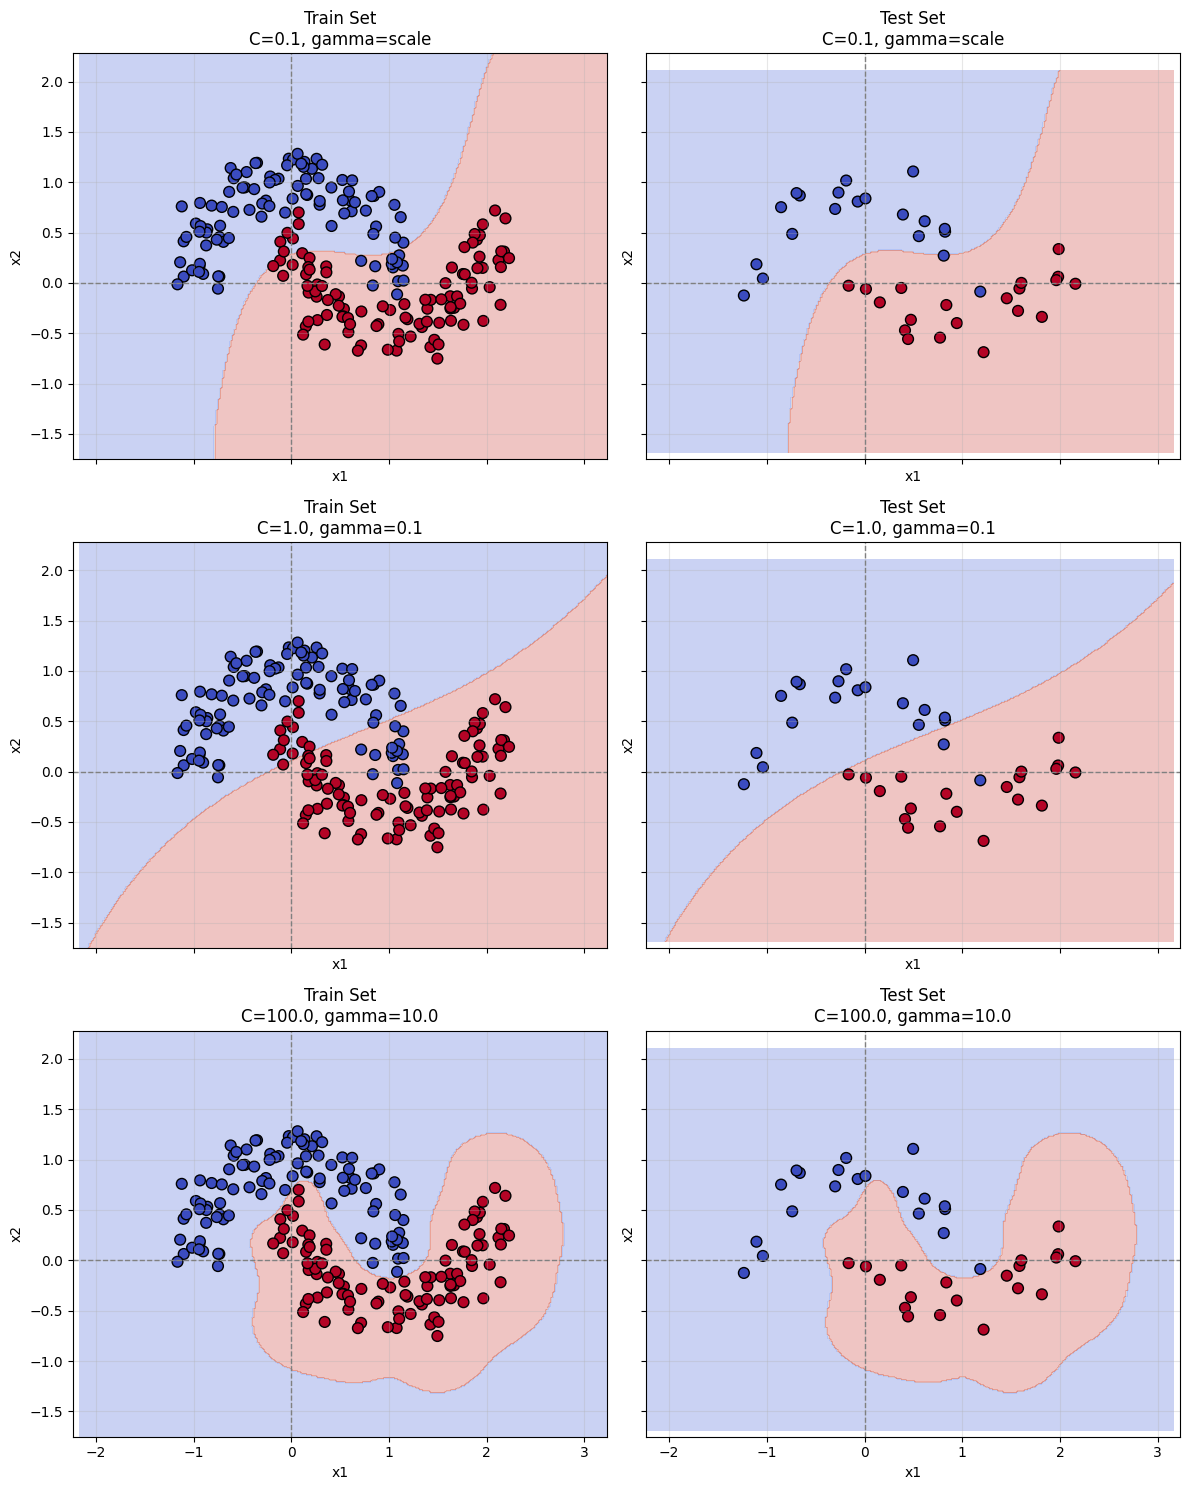

In [28]:
def plot_decision_boundaries(X, y, clf, ax, title="Decision Boundary"):
    # Reduce to 2D if necessary
    if X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)
        clf.fit(X2, y)
        xlabel, ylabel = "PC1", "PC2"
    else:
        X2 = X
        xlabel, ylabel = "x1", "x2"

    # Grid for contour
    x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
    y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X2[:,0], X2[:,1], c=y, cmap=plt.cm.coolwarm, s=60, edgecolor="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.3)

# Define 3 parameter sets
params = [
    {"C": 0.1, "gamma": "scale"},
    {"C": 1.0, "gamma": 0.1},
    {"C": 100.0, "gamma": 10.0}
]

# Create figure with 3 rows (one for each parameter set) and 2 columns (train/test)
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, param in enumerate(params):
    clf = SVC(kernel="rbf", C=param["C"], gamma=param["gamma"], random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)
    print(f"\nParameters: C={param['C']}, gamma={param['gamma']}")
    print("Train accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test accuracy :", accuracy_score(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    
    # Plot train set
    plot_decision_boundaries(X_train, y_train, clf, axes[i, 0], 
                             f"Train Set\nC={param['C']}, gamma={param['gamma']}")
    
    # Plot test set
    plot_decision_boundaries(X_test, y_test, clf, axes[i, 1], 
                             f"Test Set\nC={param['C']}, gamma={param['gamma']}")

plt.tight_layout()
plt.show()


## 3) Quantum kernel SVM (Qiskit)
We use a simple **ZZ feature map** as a starting point. Features are scaled to \([0, \pi]\). The resulting kernel is used with `SVC(kernel='precomputed')`.


In [29]:
# --- Quantum feature map ---
feature_dim = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

# --- Quantum kernel ---
qkernel = FidelityQuantumKernel(feature_map=feature_map)

# --- Compute kernel matrices ---
print("Computing training kernel...")
train_kernel_matrix = qkernel.evaluate(X_train)

print("Computing test kernel...")
test_kernel_matrix = qkernel.evaluate(X_test, X_train)

# --- Train SVM ---
clf = SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, y_train)

# --- Evaluate ---
y_pred_train = clf.predict(train_kernel_matrix)
y_pred_test = clf.predict(test_kernel_matrix)

print("Quantum Kernel SVM Results")
print("---------------------------")
print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy :", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test set):\n")
print(classification_report(y_test, y_pred_test))


Computing training kernel...
Computing test kernel...
Quantum Kernel SVM Results
---------------------------
Train accuracy: 0.735
Test accuracy : 0.65

Classification report (test set):

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        20
           1       0.71      0.50      0.59        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.64        40
weighted avg       0.66      0.65      0.64        40



In [ ]:
# --- Classical SVM ---
clf_classical = SVC(kernel='rbf', C=1.0, gamma='scale')
clf_classical.fit(X_train, y_train)

# --- Quantum feature map variants ---
quantum_variants = [
    {"reps": 2, "entanglement": "linear", "name": "Quantum (reps=2, linear)"},
    {"reps": 3, "entanglement": "linear", "name": "Quantum (reps=3, linear)"},
    {"reps": 2, "entanglement": "full",   "name": "Quantum (reps=2, full)"},
]

qsvms = []

for var in quantum_variants:
    # Feature map
    feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1],
                               reps=var["reps"],
                               entanglement=var["entanglement"])
    # Quantum kernel
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    # Compute kernels
    K_train = qkernel.evaluate(X_train)
    K_test  = qkernel.evaluate(X_test, X_train)
    # Train SVM
    clf = SVC(kernel='precomputed')
    clf.fit(K_train, y_train)
    # Store classifier and kernel
    qsvms.append((clf, qkernel, var["name"], K_train, K_test))

# --- Plotting function ---
def plot_decision_boundaries(X, y, clf, qkernel=None, title="Decision Boundary"):
    # PCA to 2D
    if X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)
    else:
        X2 = X

    x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
    y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 25),
                         np.linspace(y_min, y_max, 25))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    if X.shape[1] > 2:
        grid_points_full = pca.inverse_transform(grid_points)
    else:
        grid_points_full = grid_points

    # Decide how to compute Z
    if qkernel is not None:
        # Quantum SVM
        K_grid = qkernel.evaluate(grid_points_full, X_train)
        Z = clf.decision_function(K_grid)
    else:
        # Classical SVM
        Z = clf.decision_function(grid_points_full)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X2[:,0], X2[:,1], c=y, cmap=plt.cm.coolwarm, s=60, edgecolor="k")
    plt.xlabel("PC1" if X.shape[1] > 2 else "x1")
    plt.ylabel("PC2" if X.shape[1] > 2 else "x2")
    plt.title(title)
    plt.grid(alpha=0.3)

# --- Plot 2x3 figure ---
fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()

# Classical SVM plots
plt.sca(axes[0])
plot_decision_boundaries(X_train, y_train, clf_classical, qkernel=None, title="Classical SVM — Train")
plt.sca(axes[1])
plot_decision_boundaries(X_test, y_test, clf_classical, qkernel=None, title="Classical SVM — Test")

# Quantum SVM plots
for i, (clf, qkernel, name, K_train, K_test) in enumerate(qsvms):
    plt.sca(axes[2+i*2])
    plot_decision_boundaries(X_train, y_train, clf, qkernel=qkernel, title=f"{name} — Train")
    plt.sca(axes[2+i*2+1])
    plot_decision_boundaries(X_test, y_test, clf, qkernel=qkernel, title=f"{name} — Test")

plt.tight_layout()
plt.show()

# --- Compute test accuracies ---
results = []

# Classical SVM
acc_train = accuracy_score(y_train, clf_classical.predict(X_train))
acc_test  = accuracy_score(y_test,  clf_classical.predict(X_test))
results.append(("Classical SVM", acc_train, acc_test))

# Quantum SVM variants
for clf, qkernel, name, K_train, K_test in qsvms:
    y_pred_train = clf.predict(K_train)
    y_pred_test  = clf.predict(K_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test  = accuracy_score(y_test, y_pred_test)
    results.append((name, acc_train, acc_test))

# --- Plot 2x3 figure ---
fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()

# Classical SVM plots
plt.sca(axes[0])
plot_decision_boundaries(X_train, y_train, clf_classical, qkernel=None, title="Classical SVM — Train")
plt.sca(axes[1])
plot_decision_boundaries(X_test, y_test, clf_classical, qkernel=None, title="Classical SVM — Test")

# Quantum SVM plots
for i, (clf, qkernel, name, K_train, K_test) in enumerate(qsvms):
    plt.sca(axes[2+i*2])
    plot_quantum_decision_boundaries(X_train, y_train, qkernel, clf, title=f"{name} — Train")
    plt.sca(axes[2+i*2+1])
    plot_quantum_decision_boundaries(X_test, y_test, qkernel, clf, title=f"{name} — Test")

plt.tight_layout()
plt.show()

# --- Print summary table of accuracies ---
print("\nTest accuracies summary:")
print("{:<30} {:>10} {:>10}".format("Model", "Train", "Test"))
print("-"*55)
for name, acc_train, acc_test in results:
    print("{:<30} {:>10.3f} {:>10.3f}".format(name, acc_train, acc_test))


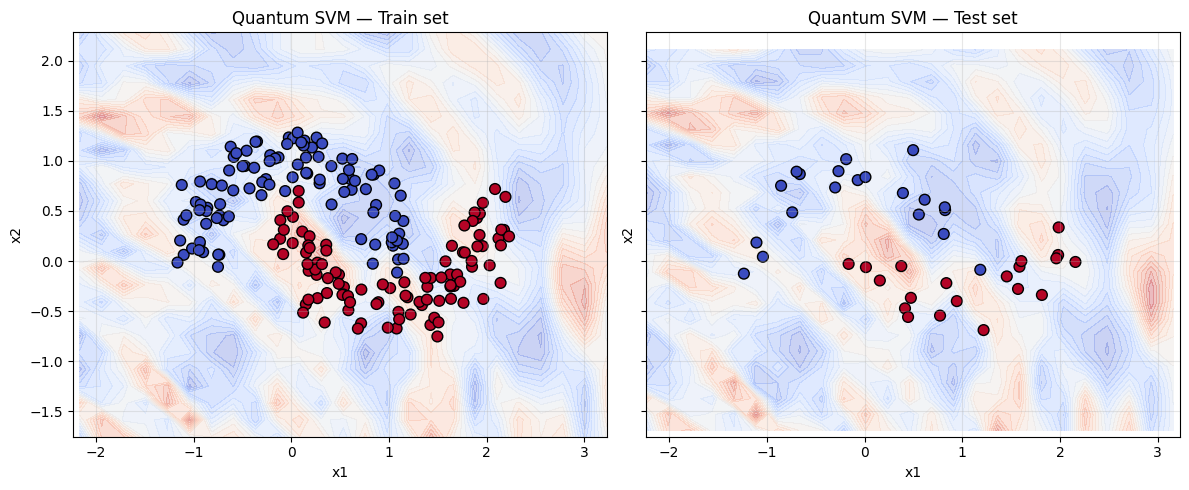

In [ ]:
# --- Function to plot decision boundaries ---
def plot_quantum_decision_boundaries(X, y, qkernel, clf, title="Quantum SVM Decision Boundary"):
    # Reduce to 2D if necessary
    if X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)
    else:
        X2 = X

    # Grid for contour plot (smaller for speed)
    x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
    y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 25),
                         np.linspace(y_min, y_max, 25))

    # Flatten grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    if X.shape[1] > 2:
        grid_points_full = pca.inverse_transform(grid_points)
    else:
        grid_points_full = grid_points

    # Compute kernel between grid points and training data
    K_grid = qkernel.evaluate(grid_points_full, X_train)
    Z = clf.decision_function(K_grid)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, levels=20, cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X2[:,0], X2[:,1], c=y, cmap=plt.cm.coolwarm, s=60, edgecolor="k")
    plt.xlabel("PC1" if X.shape[1] > 2 else "x1")
    plt.ylabel("PC2" if X.shape[1] > 2 else "x2")
    plt.title(title)
    plt.grid(alpha=0.3)

# --- Plot side by side: Train vs Test ---
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(axes[0])
plot_quantum_decision_boundaries(X_train, y_train, qkernel, clf, "Quantum SVM — Train set")

plt.sca(axes[1])
plot_quantum_decision_boundaries(X_test, y_test, qkernel, clf, "Quantum SVM — Test set")

plt.tight_layout()
plt.show()


### (Optional) Learnable quantum kernel parameters
We add trainable parameters to the feature map and optimize them by maximizing **kernel-target alignment** on the training set.


In [22]:
if qiskit_available:
    # Example: add a single parameter per feature block and optimize with a simple grid/random search.
    n_features = X_train.shape[1]
    thetas = ParameterVector('theta', n_features)

    def param_feature_map(num_features, reps=1):
        qc = QuantumCircuit(num_features)
        for i in range(num_features):
            qc.h(i)
        for _ in range(reps):
            for i in range(num_features):
                # Encode data on RY with a learnable scale factor theta[i]
                qc.ry(thetas[i], i)
            for i in range(num_features - 1):
                qc.cz(i, i+1)
        return qc

    pmap = param_feature_map(n_features, reps=2)
    
    def kernel_with_params(params, XA, XB):
        bound_circuit = pmap.bind_parameters({thetas[i]: params[i] for i in range(n_features)})
        qk = QuantumKernel(feature_map=bound_circuit)
        return qk.evaluate(XA, XB)

    # Angle scaling again
    scaler_for_angles2 = MinMaxScaler(feature_range=(0, np.pi))
    XA = scaler_for_angles2.fit_transform(X_train)
    XB_train = scaler_for_angles2.transform(X_train)
    XB_test  = scaler_for_angles2.transform(X_test)

    # Simple random search over parameters in [0, pi]
    num_trials = 10
    best_align, best_params = -np.inf, None

    # Centered alignment function
    def kernel_target_alignment(K, y):
        y_pm = (2*y - 1).astype(float)  # convert {0,1} -> {-1,+1}
        Y = np.outer(y_pm, y_pm)
        # Frobenius inner product normalized
        num = np.sum(K * Y)
        den = np.sqrt(np.sum(K * K) * np.sum(Y * Y))
        return num / den

    for t in range(num_trials):
        params = RNG.uniform(0, np.pi, size=n_features)
        Kt = kernel_with_params(params, XA, XB_train)
        align = kernel_target_alignment(Kt, y_train)
        if align > best_align:
            best_align, best_params = align, params

    print("Best alignment:", best_align)
    print("Best params (first 10):", best_params[:min(10, len(best_params))])

    # Train with best params
    K_train_best = kernel_with_params(best_params, XA, XB_train)
    K_test_best  = kernel_with_params(best_params, scaler_for_angles2.transform(X_test), XB_train)

    qsvc_best = SVC(kernel='precomputed')
    qsvc_best.fit(K_train_best, y_train)
    y_pred_best = qsvc_best.predict(K_test_best)

    print("Learnable-params Quantum kernel SVM — Test accuracy:", accuracy_score(y_test, y_pred_best))
    print("\nClassification report:\n", classification_report(y_test, y_pred_best))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
else:
    print("Qiskit not available — skip this optional section.")


Qiskit not available — skip this optional section.


## 4) Save figures & notes for your report
Use the cells above to generate the plots you need (decision boundaries, confusion matrices, etc.).
Below is a small helper to save arrays/plots if needed.


In [ ]:
# Example: save a figure
# plt.figure(); ... (your plot) ; plt.savefig('classical_decision_boundary.png', dpi=150, bbox_inches='tight')
# print("Saved classical_decision_boundary.png")
